In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
import numpy as np
import time
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, hamming_loss
from sklearn.metrics import jaccard_score

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# fix random seed for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
seed = 85497648
# seed = 963852741
np.random.seed(seed)
random.seed(123)

NUM_PARALLEL_EXEC_UNITS = 4
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS, inter_op_parallelism_threads=2,
                              allow_soft_placement=True, device_count={'CPU': NUM_PARALLEL_EXEC_UNITS})

tf.random.set_seed(123)

sess = tf.compat.v1.Session(config=session_conf)

os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)

os.environ["KMP_BLOCKTIME"] = "30"

os.environ["KMP_SETTINGS"] = "1"

os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"


## Definition of Evaluation Metrics for Model Training and Validation

Since Keras (with the TensorFlow backend) does not directly provide some relevant metrics through keras.metrics, it was necessary to implement them manually for this work.

Specifically, the following metrics were implemented: F1-Score (weighted), Hamming Loss, and Hamming Score, considering their suitability for the multilabel classification context. The implementation of these metrics is presented in the following cell.


In [5]:
def f1_score_weighted(y_true, y_pred):
    y_pred = K.round(y_pred)
    y_true = K.cast(y_true, K.floatx()) # Converte y_true para float32
    y_pred = K.cast(y_pred, K.floatx()) # Converte y_true para float32


    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Weighting by support (number of samples per class)
    support = K.sum(y_true, axis=0)
    f1_weighted = K.sum(f1 * support) / K.sum(support)

    return f1_weighted

def hamming_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    intersection = K.sum(y_true * y_pred, axis=1)
    union = K.sum(K.cast(K.greater(y_true + y_pred, 0), tf.float32), axis=1)

    score = intersection / (union + K.epsilon())  # avoid division by zero
    return K.mean(score)

def hamming_loss_m(y_true, y_pred):
    y_pred = K.round(y_pred)  # Arredonda para 0 ou 1
    y_true = K.cast(y_true, K.floatx())  # Converte y_true para float32
    correct = K.equal(y_true, y_pred)
    return 1-K.mean(K.cast(correct, K.floatx()))

## Dataset Loading

The dataset used contains 11,205 frequency records of events detected in the Brazilian Interconnected Power System (BIPS) over a 12-year period, including both historical event data and records obtained from the application of the event detection methodology proposed in [1]. All records were manually inspected, and one or more event classes were assigned to each detection based on the observed dynamics: Line Tripping (LnT), Electromechanical Oscillations (EO), Loss of Load (LoL) and Generation Tripping (GT). As a result, 9,009 records were labeled with the LnT class, 4,940 with EO, 713 with LoL, and 1,141 with GT.



Nevertheless, due to confidentiality restrictions, the dataset cannot be shared publicly.



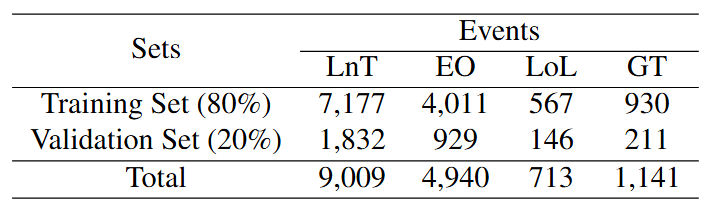


[1] Gabriel V. de S. Lopes, Guido R. Moraes, Diego Issicaba, Daniel Dotta, WAMS-based two-level robust detection methodology of power system events, Sustainable Energy, Grids and Networks, Volume 31, 2022, 100689, ISSN 2352-4677, https://doi.org/10.1016/j.segan.2022.100689.

In [28]:
rlist = np.load('/content/drive/MyDrive/Dados_10_22/Train_Events_10_22_normalizado_class_multilabel_2.npz', allow_pickle=True)
X_train = rlist['data']
Train_label_class = rlist['label']
Y_train = np.array(Train_label_class)

# Reshaping the input data matrix to the channel-last format
number_rows, number_cols = X_train.shape[1], X_train.shape[2]
TrainX_arr = X_train.reshape(X_train.shape[0], number_rows, number_cols, 1)

In [29]:
rlist = np.load('/content/drive/MyDrive/Dados_10_22/Val_Events_10_22_normalizado_class_multilabel_2.npz', allow_pickle=True)
X_val = rlist['data']
Val_label = rlist['label']
Y_val = np.array(Val_label)

# Reshaping the input data matrix to the channel-last format
valX_arr = X_val.reshape(X_val.shape[0], number_rows, number_cols, 1)

## Function: create_model ()

The CNN architecture consists of three convolutional layers, each one with 256, 256, and 64 filters, respectively, all using rectified linear unit (ReLU) activation. Each convolutional layer is followed by batch normalization, max-pooling, and dropout layers with rates of 0.5, 0.5, and 0.6, respectively. In the classification stage, the resulting feature maps are flattened and passed through a fully connected layer with 100 neurons and ReLU activation, followed by batch normalization, a dropout layer (rate = 0.5), and a sigmoid-activated output layer with four neurons which maps the values to the range between 0 and 1. Thus, each classifier's output corresponds to the probability of the sample belonging to the classes.





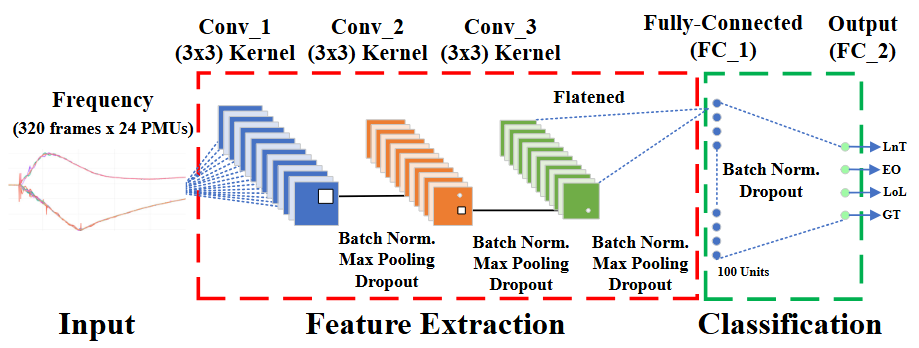

In [8]:
# Function to create model, required for KerasClassifier

# 320 Frames x 24 PMUs x 1 channel
Shape_input = (number_rows, number_cols, 1)

def create_model():

    model = Sequential()
    model.add(Input(shape=Shape_input))
    model.add(Conv2D(256, kernel_size=(3, 3),
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum =0.9))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5, seed=66))


    model.add(Conv2D(256, kernel_size=(3, 3),
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.5, seed=66))


    model.add(Conv2D(64, kernel_size=(3, 3),
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.6, seed=66))


    model.add(Flatten())

    model.add(Dense(100,
                    kernel_initializer=initializers.glorot_uniform(seed=66),
                    activation=tf.nn.relu,
                    kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization(momentum = 0.9))
    model.add(Dropout(0.5, seed=66))

    model.add(Dense(4,
                    kernel_initializer=initializers.glorot_uniform(seed=66),
                    activation=None))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('sigmoid'))


    model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005,  beta_1=0.9, beta_2=0.999),
              metrics=['accuracy', hamming_loss_m, hamming_score , f1_score_weighted]
              )


    return model


In [9]:
model = create_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 318, 22, 256)   │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 318, 22, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 11, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 159, 11, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 9, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 157, 9, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 79, 5, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 79, 5, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 77, 3, 64)      │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 77, 3, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 39, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 39, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4992)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       499,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,242,584 (4.74 MB)

 Trainable params: 1,241,224 (4.73 MB)

 Non-trainable params: 1,360 (5.31 KB)

## Model Training

The model will initially be trained for up to 200 epochs, with a batch size of 32. However, if no improvement in performance is observed—measured by a reduction in validation loss greater than 0.0001 over 10 consecutive epochs—the training will be stopped early. The applied early stopping technique aims to prevent model overfitting, ensuring better generalization.

In [10]:
nb_epoch = 200
batch_size =32

time_start = time.time()

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors the validation metric
    patience=10,          # Number of epochs without improvement before stopping
    min_delta=0.0001,
    mode='min',
    restore_best_weights=True  # Restores the best weights at the end of training
)

history = model.fit(TrainX_arr,Y_train, validation_data=(valX_arr, Y_val),  epochs=nb_epoch, batch_size=batch_size, verbose=2, callbacks=[early_stopping ])
time_elapsed = (time.time() - time_start)

print('elapsed time best model (min):', time_elapsed / 60)

In [11]:
from matplotlib import pyplot

# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='Training')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()


# plot accuracy during training
pyplot.subplot(211)
pyplot.title('F1-score')
pyplot.plot(history.history['f1_score_weighted'], label='Training')
pyplot.plot(history.history['val_f1_score_weighted'], label='Validation')
pyplot.legend()


# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Hamming Score')
pyplot.plot(history.history['hamming_score'], label='Training')
pyplot.plot(history.history['val_hamming_score'], label='Validation')
pyplot.legend()

plt.subplots_adjust(hspace=0.5)

pyplot.show()


# plot accuracy during training
pyplot.subplot(111)
pyplot.title('Hamming Loss')
pyplot.plot(history.history['hamming_loss_m'], label='Training')
pyplot.plot(history.history['val_hamming_loss_m'], label='Validation')
pyplot.legend()

plt.subplots_adjust(hspace=0.5)

pyplot.show()

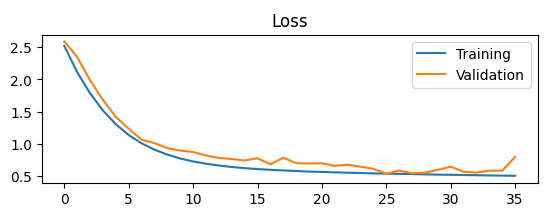


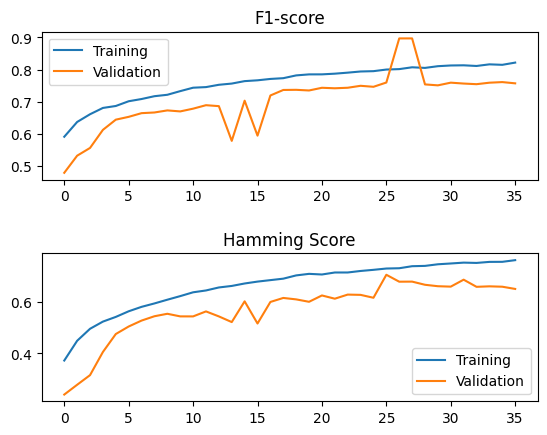

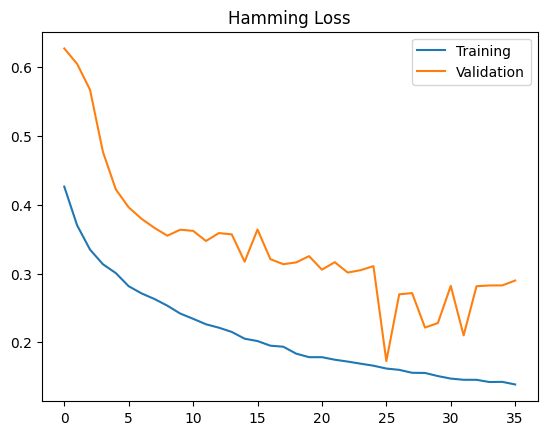



In [12]:
# Saves the trained model weights for future use
# model.save_weights('/kaggle/working/CNN_3_camadas_classificacao_multilabel.weights.h5')

## Model performance evaluation
After model training, performance metrics for both the validation and training datasets are presented below.

This process is performed through thresholding, where the outputs of the multi-label classifier are compared against predefined thresholds. If the probability associated with an output exceeds its corresponding threshold, the class related to that output is assigned to the sample. The final result is a binary vector, with each element indicating the presence (1) or absence (0) of a specific class. In this study, thresholds were determined via grid search optimization aimed at minimizing the Hamming loss on the training set. The resulting thresholds were: 0.5 for LnT events, 0.482 for EO, 0.3 for LoL, and 0.49 for GT.

In [27]:
# Loads trained model
model.load_weights('/content/drive/MyDrive/CNN_Multilabel/CNN_3_camadas_classificacao_multilabel.weights.h5')

thresholds = [0.5, 0.482, 0.3, 0.49]

train_pred = model.predict(TrainX_arr, batch_size=1)
train_pred = (train_pred > thresholds).astype(int)

val_pred = model.predict(valX_arr, batch_size=1)
val_pred = (val_pred > thresholds).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8964/8964 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step
2241/2241 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step


## Model performance metrics on the training dataset

In [33]:
print('Model performance metrics on the training dataset: ')
f1_weighted = f1_score(Y_train , train_pred, average='weighted')
print("F1 score: ",f1_weighted)
hamming = hamming_loss(Y_train , train_pred)
print("Hamming_loss: ", hamming)
print("Hamming_score: ", jaccard_score(Y_train , train_pred, average='samples'))
print(classification_report(Y_train, train_pred, target_names=["LnT", "EO", "LoL", "GT"]))

Model performance metrics on the training dataset: 
F1 score:  0.8974708008673756
Hamming_loss:  0.07396251673360107
Hamming_score:  0.8664658634538153
              precision    recall  f1-score   support

         LnT       0.91      0.99      0.95      1794
          EO       0.76      0.93      0.84       966
         LoL       0.87      0.78      0.83       139
          GT       0.99      0.65      0.79       218

   micro avg       0.86      0.94      0.90      3117
   macro avg       0.88      0.84      0.85      3117
weighted avg       0.87      0.94      0.90      3117
 samples avg       0.89      0.96      0.91      3117



## Model performance metrics on the validation dataset

In [34]:
print('Model performance metrics on the validation dataset: ')
f1_weighted = f1_score(Y_val, val_pred, average='weighted')
print("F1 score: ",f1_weighted)
hamming = hamming_loss(Y_val, val_pred)
print("Hamming_loss: ", hamming)
print("Hamming_score: ", jaccard_score(Y_val, val_pred, average='samples'))

print(classification_report(Y_val, val_pred, target_names=["LnT", "EO", "LoL", "GT"]))

Model performance metrics on the validation dataset: 
F1 score:  0.8883688880085794
Hamming_loss:  0.08001450245426149
Hamming_score:  0.8589078536367692
              precision    recall  f1-score   support

         LnT       0.90      0.99      0.94      7215
          EO       0.77      0.94      0.85      3974
         LoL       0.88      0.70      0.78       574
          GT       0.99      0.57      0.72       923

   micro avg       0.86      0.93      0.89     12686
   macro avg       0.88      0.80      0.82     12686
weighted avg       0.87      0.93      0.89     12686
 samples avg       0.89      0.95      0.90     12686



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
